# Mini-project n° 2 – Conditional VAEs

In [16]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
import itertools
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


## Objectifs du projet

Le but de ce projet est de créer un modèle d'autoencodeur variationnel conditionnel (VAE conditionnel) capable de générer des images inspirées d'un jeu de données (Fashion MNIST) représentant des vêtements et accessoires de mode.

Dans un premier temps, on veut donc crée un modèle d'autoencodeur qui prenne en entrée des données (dans notre cas des images), les projette dans un espace latent de plus faible dimension via un encodeur, et soit ensuite capable de reconstruire ces images via un décodeur.

Dans un second temps, on pourra utiliser la partie décodeur afin de générer de nouvelles images qui n'appratiennent pas au jeu de données initial mais y ressemblent.

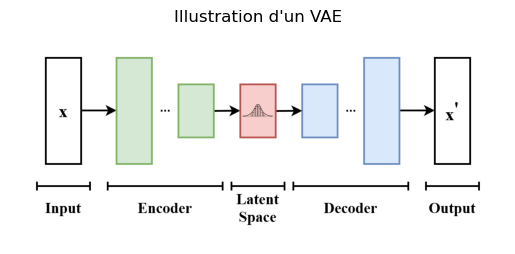

In [17]:
image_path = "Schema_VAE.png"
img = mpimg.imread(image_path)

# Affichage
plt.imshow(img)
plt.axis('off')
plt.title("Illustration d'un VAE")
plt.show()

Source : Numiri. (2021). VAE blocks [Image]. Wikimedia Commons. https://commons.wikimedia.org/wiki/File:VAE_blocks.png <br>
L'image est utilisée sous la licence Creative Commons Attribution-Share Alike 4.0 International (CC BY-SA 4.0).

## Analyse exploratoire des données

In [19]:
batch_size = 128 # hyperparamètre nécessaire au chargement des loaders

In [20]:
# Chargement des données
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
print("Nombre d'images dans le jeu de données d'apprentissage :", len(train_dataset))
print("Nombre d'images dans le jeu de données test :", len(test_dataset))


Nombre d'images dans le jeu de données d'apprentissage : 60000
Nombre d'images dans le jeu de données test : 10000


On voudrait maintenant visualiser quelques images de notre jeu de données original. Notre jeu de données contient en fait des images provenant de 10 classes de vêtements et accessoires différentes.

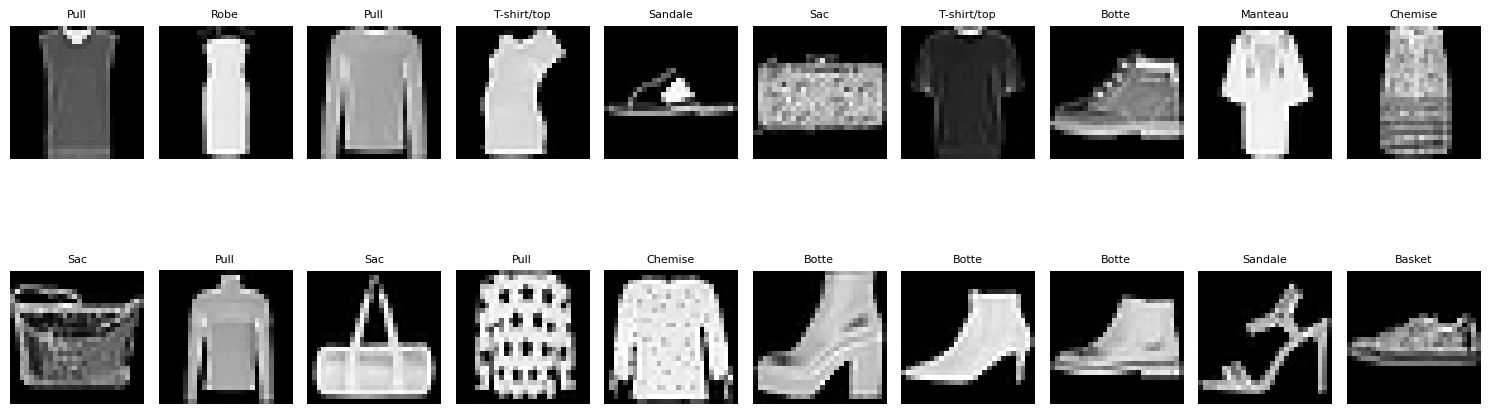

In [8]:
# Classes dans FashionMNIST
classes = [
    "T-shirt/top", "Pantalon", "Pull", "Robe", "Manteau",
            "Sandale", "Chemise", "Basket", "Sac", "Botte"
]

# On sélectionne un lot d'images depuis le DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)

def show_images(images, labels, classes, n=20):
    # Sélectionner les n premières images
    images = images[:n]
    labels = labels[:n]
    
    fig, axes = plt.subplots(2, 10, figsize=(15, 6))
    axes = axes.ravel()

    for i in range(n):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(classes[labels[i].item()], fontsize=8)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Afficher 20 images de chaque classe
show_images(images, labels, classes, n=20)

On voudrait également savoir si la répartition des classes est équitable dans le jeu de données.

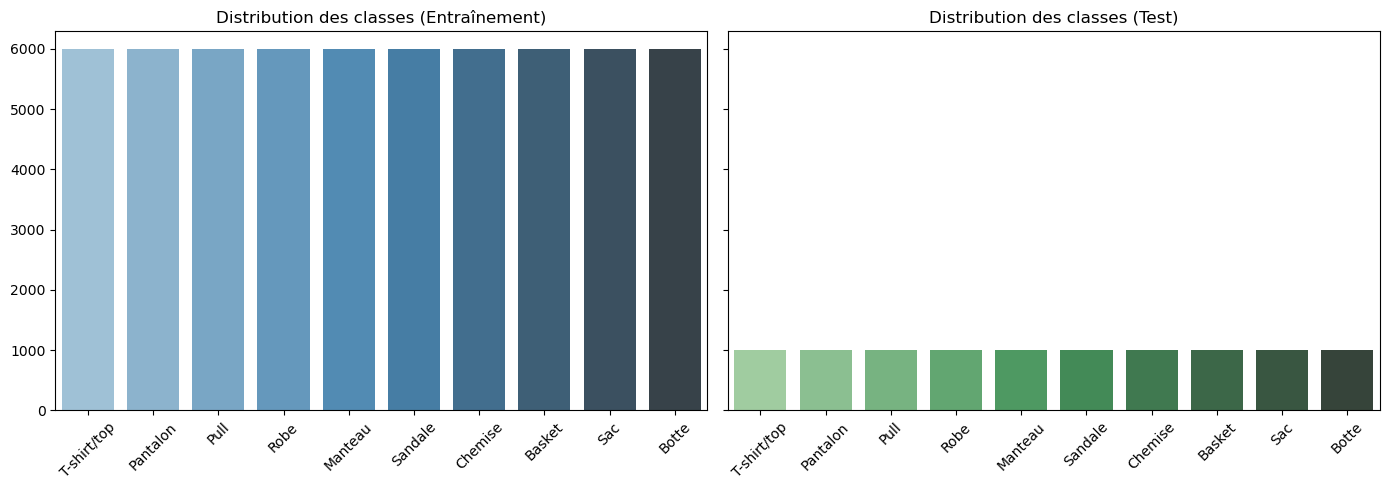

In [13]:
warnings.filterwarnings("ignore")

# Calcul des distributions des classes pour l'entraînement et le test
train_class_counts = [0] * len(classes)
test_class_counts = [0] * len(classes)

for _, label in train_dataset:
    train_class_counts[label] += 1
for _, label in test_dataset:
    test_class_counts[label] += 1

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Graphique pour l'entraînement
sns.barplot(x=classes, y=train_class_counts, ax=axes[0], palette="Blues_d")
axes[0].set_title("Distribution des classes (Entraînement)")
axes[0].set_xticklabels(classes, rotation=45)

# Graphique pour le test
sns.barplot(x=classes, y=test_class_counts, ax=axes[1], palette="Greens_d")
axes[1].set_title("Distribution des classes (Test)")
axes[1].set_xticklabels(classes, rotation=45)

plt.tight_layout()
plt.show()


Nos jeux de données sont donc parfaitement équilibrés.

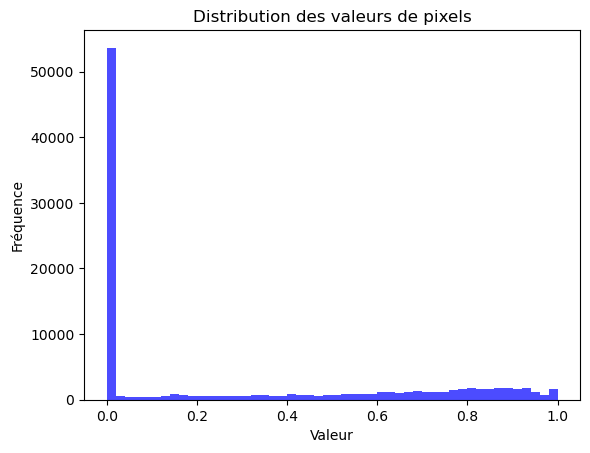

In [14]:
pixel_values = images.numpy().ravel()
plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
plt.title("Distribution des valeurs de pixels")
plt.xlabel("Valeur")
plt.ylabel("Fréquence")
plt.show()

Enfin, on voudrait analyser les caractéristiques visuelles de chaque classe. Pour cela, pour chaque classe de notre jeu de données d'entraînement, on crée une image et on colorie chaque  pixel de l'image en fonction de la valeur moyenne de coloration obtenue sur l'ensemble des images de la classe. Cela nous donne deux informations :

- La variabilité intra-classes : si l'image finale obtenue semble "floue" alors les images de la classe sont variées, et au contraire si elle semble nette alors c'est que la classe est visuellement homogène.

- La variabilité inter-classes : En comparant les images moyennes de différentes classes, on peut visualiser si certaines classes sont facilement distinguables ou s'il existe des similitudes.

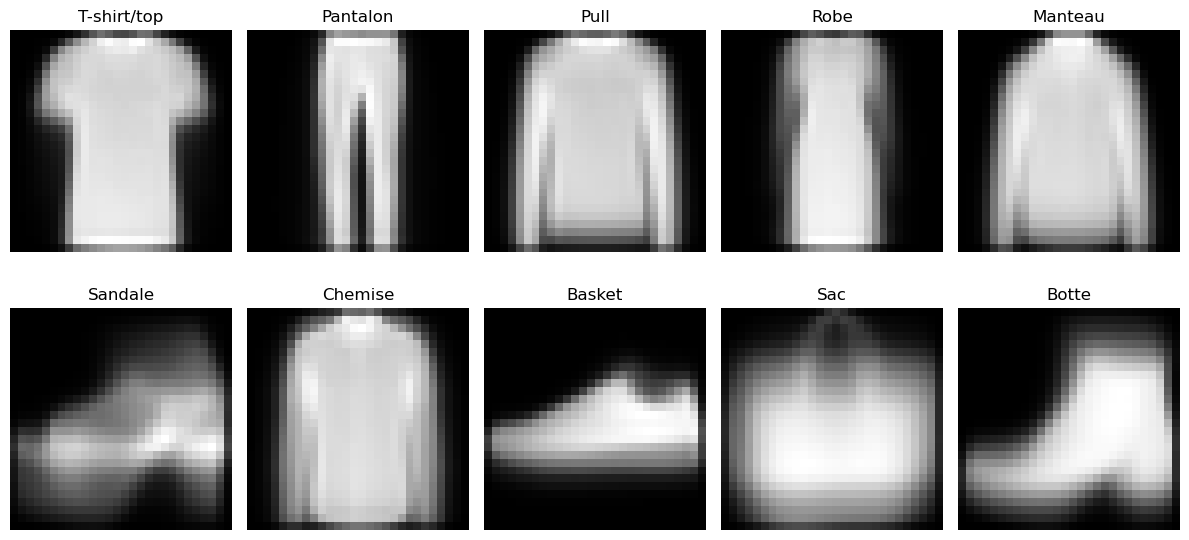

In [15]:
class_sums = [np.zeros((28, 28)) for _ in range(len(classes))]
class_counts = [0] * len(classes)

for image, label in train_dataset:
    class_sums[label] += np.array(F.to_pil_image(image))
    class_counts[label] += 1

# Calcul des moyennes pour chaque classe
class_means = [class_sums[i] / class_counts[i] for i in range(len(classes))]

# Visualisation des moyennes par classe
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i in range(len(classes)):
    axes[i].imshow(class_means[i], cmap='gray')
    axes[i].set_title(classes[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()


On constate que certaines classes comme les sandales et les salles ont des variabilités intra-classes assez importantes : les modèles du jeu de données sont donc assez variés pour ces classes. Au contraire les t-shirt et les pantalons sont relativement homogènes.

Par ailleurs, il semble plus difficile de pouvoir distinguer visuellement un pull d'un manteau ou encore une sandale d'une botte. Il y a donc des similtudes pour certaines classes.

## Listes des hyperparamètres

Les hyperparamètres de notre modèle sont : 

- batch size = Le nombre d'échantillons sur lesquels le modèle apprend avant de mettre à jour ses paramètres internes (poids du réseau...)
- epochs = Le nombre de fois où l'entièreté du jeu de données est utilisée pour l'apprentissage. Une valeur trop faible peut conduire à du sous-apprentissage et au contraire une valeur trop élevée à du surapprentissage
- latent_dim = La taille de l'espace latent
- learning_rate = Le taux d'apprentissage. Il contrôle la vitesse à laquelle le modèle apprend.
- beta = Ajuste l'importance de la divergence dans la fonction de perte

La fonction de perte utilisée ci-après est définie de la manière suivante :

<div style="text-align: center;">
    Loss = BCE + beta * KLD
</div>
où BCE correspond à la "Binary Cross-Entropy" et KLD est la Divergence KL

Le premier terme est un terme de reconstruction : il mesure à quel point le réseau reconstruit correctement les données d’origine à partir de l’espace latent.
Le second terme est un terme de régularisation : il mesure à quel point la distribution de l'espace latent se rapproche d'une loi normale centrée réduite.

Ainsi, 3 cas sont à distinguer concernant le paramètre beta :

- beta = 1 : On accorde autant d'importance à la reconstruction qu'à la régularisation.
- beta > 1 : On donne davantage de poids à la régularisation. On fait en sorte que la distribution de l'espace latent se rapproche au plus d'une gaussienne centrée réduite. Cependant, cela peut diminuer la capacité de reconstruction du modèle.
- beta < 1 : On donne davantage de poids à la reconstruction. Le modèle apprend ainsi à capturer plus de détails dans l'image. Cependant, cela peut augmenter le risque de surapprentissage.

In [18]:
# Liste des hyperparamètres

# batch_size déja défini auparavant
epochs = 5
latent_dim = 2
learning_rate = 1e-3
beta = 1
kl_weights = [0.5, 1, 10, 100] # differentes valeurs de beta utilisees pour la visualisation de l'espace latent

# Autres paramètres
nb_classes=10

## VAE Standards VS. VAE Conditionnels

Les Autoencodeurs Variationnels Conditionnels (VAEs Conditionnels) s'appuient, tout comme les VAE standards, sur un modèle encodeur  - décodeur avec compression des données dans un espace latent intermédiaire.

La principale différence est l'introduction d'entrées conditionnelles qui permettent au modèle de générer des échantillons de données en fonction de conditions ou d'attributs spécifiques. L'espace latent est lui même un espace latent conditionnel, la distribution de la variable latente $z$ dépendant de ces attributs.

Les informations présentées dans ce projet proviennent des sources suivantes:

- Nicolas Thome, Clément Rambour, Nicolas Audebert. Auto-encodeurs variationnels. Cnam. https://cedric.cnam.fr/vertigo/cours/RCP211/auto-encodeurs-variationnels.html. 2023.
- Nicolas Thome, Clément Rambour, Nicolas Audebert. Auto-encodeurs variationnels. Cnam. https://cedric.cnam.fr/vertigo/cours/RCP211/TP8-CVAE_PixelCNN.html. 2024
- Joseba Dalmau. Autoencoders and Variational Autoencoders. 2024


### VAE standards

En effet, dans un modèle de VAE "classique" le modèle de génération des données est obtenu via la formule suivante : 

$p(x) = \int p(x|z) p(z) dz$, intégrale difficile à calculer. On cherche alors plutôt à approximer $p(z|x)$ $\Bigl($ avec $p(z|x) = \frac{p(x|z) p(z)}{p(x)} \Bigr)$ qu'on ne connaît pas non plus mais qu'on veut approximer par une autre distribution $q(z|x)$.

Pour choisir $q(z|x)$, on veut s’approcher au maximum du véritable postérieur $p(z|x)$. On cherche pour cela à trouver les paramètres de $q $ qui minimisent l’écart entre les deux distributions. Le choix le plus courant pour mesurer cet écart est de calculer la divergence de Kullback-Leibler entre les deux probabilités, donnée par la formule suivante : 

$$KL(q(x)||p(x)) = \mathbb{E}_{q}(x)[log \:q(x)−log \:p(x)]$$

Minimiser cette divergence revient en fait à maximiser l'expression :

$$\mathbb{E}_{q(z|x)}[log \:p(x|z)]−KL(q(z|x)||p(z))$$

Ce terme est maximisé lorsque l'on a :

1- la maximisation de la log-vraisemblance, c’est-à-dire que les variables latentes $z$ permettent de prédire correctement x <br>
2- la minimisation d’une pénalité correspondant à la divergence entre $q$ et l'a priori $p$

### VAE conditionnels

Dans un VAE conditionnel, on l'a dit précédemment, la variable latente $z$ est condtionnée par c. Nous avons donc un espace latent et une distribution $p(z)$
différents pour chaque valeur du conditionnement c. Dans ce cas là, l'expression que l'on cherche alors  à minimiser est la suivante :

$$\mathbb{E}_{q(z|x,c)}[log \:p(x|z,c)]−KL(q(z|x,c)||p(z|c))$$


## Création d'un modèle d'AutoEndodeur Variationnel Conditionnel (Conditionnal VAE)

Le modèle de VAE conditionnel utilisé par la suite se construit de la manière suivante :

- **Un Encodeur** : 
    - Une couche de convolution composée de 32 filtres, un noyau de taille 4, un stride de 2 et un padding de 1.
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques.
    - Une fonction d'activation ReLu.
    - Une couche de convolution composée de 64 filtres, un noyau de taille 4, un stride de 2 et un padding de 1.
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques.
    - Une fonction d'activation ReLu.
    - Une couche de convolution composée de 128 filtres, un noyau de taille 3, un stride de 2 et un padding de 1..
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques.
    - Une fonction d'activation ReLu.

- **Un Espace Latent** :

Il est composé de deux couches parallèles dites "entièrement connectées" (en d'autres termes tous les neurones sont connectés à ceux de la couche précédente, qui est ici la sortie de l'encodeur E(x)).

- La première couche estime un vecteur moyenne µ(x)
- La seconde couche estime un vecteur de log-variance $\log\sigma^2(x)$

Une dernière couche entièrement connectée utilise alors ces informations pour renvoyer la variable latente z selon une distribution gaussienne : $z(x)\sim\mathcal{N}(\mu(x),Diag(\sigma(x)))$ 

- **Un Décodeur.** 
    - Une couche de déconvolution composée de 64 filtres, un noyau de taille 3, un stride de 2 et un padding de 1.
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques
    - Une fonction d'activation ReLu
    - Une couche de déconvolution composée de 32 filtres, un noyau de taille 4, un stride de 2 et un padding de 1.
    - Une couche BatchNorm qui conserve le même nombre de caractérstiques
    - Une fonction d'activation ReLu
    - Une couche de déconvolution composée de 1 filtre, un noyau de taille 4, un stride de 2 et un padding de 1.
    - Une fonction d'activation Sigmoïde

**Au niveau de l'encodeur :**

Pour chacune des couches de convolution :
- Un filtre (ou noyau) est une matrice de poids qui parcourt l’image d’entrée pour extraire des caractéristiques spécifiques (de manière générale comme des contours ou des textures). La sortie de la couche est obtenue à partir d'une convolution entre l'objet en entrée et le filtre. Le paramètre kernel_size désigne la taille de la matrice.
- Un filtre apprend UNE caractéristique de l’image donc, plus il y a de filtres, plus le modèle retient de caractéristiques.
- Le stride indique de combien de pixels le filtre se déplace à chaque étape lorsqu’il parcourt l’image d’entrée (d'abord horizontalement puis verticalement). 
- Le padding consiste à ajouter des pixels autour de l'image pour essayer de préserver l'information sur les bords de l'image. Un padding de 1 signfie que l'on ajoute une rangée de pixel tout autour de l'image

L’augmentation progressive du nombre de filtres dans les couches de convolution permet de capturer des caractéristiques de plus en plus complexes des données d’entrée : les couches proches de l'entrée capturent des motifs de base et au fur et à mesure que l’on avance dans le réseau, on veut que chaque couche représente des détails plus sophistiqués. Avoir plus de filtres permet à chaque couche de détecter des motifs plus variés et spécifiques.

La couche BatchNorm permet de normaliser les sorties d'une couche de réseau lors de l'apprentissage.

**Au niveau du décodeur :**

La fonction d'activation utilisée en sortie est la fonction Sigmoïde. Elle renvoie des valeurs comprises entre 0 et 1 , ce qui est utile puisqu' avec ce réseau on cherche à générer des images en noir et blanc. Les résultats obtenus permettent donc directement d'obtenir des nuances de gris.




**Le vecteur de conditionnement c** :

Donne une information/une étiquette sur les données. Ici c indique la valeur numérique associée à une image du jeu de données (ie le numéro de la classe représentée).
La variable latente z est alors conditionnée par c.

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=10, num_classes=10):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4 + num_classes, latent_dim) # (128*4*4) est la taille de sortie de la couche précédente
        self.fc_logvar = nn.Linear(128 * 4 * 4 + num_classes, latent_dim) 
        self.fc_decode = nn.Linear(latent_dim + num_classes, 128 * 4 * 4) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x, c):
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4) # "Applatissement" de la sortie après convolution (on restructure les donnes pour que x et c soient de meme taille)
        x = torch.cat((x,c),dim=1) # Concaténation de x et c
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

    def latent_sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        z = torch.cat((z,c),dim=1)
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.latent_sample(mu, logvar)
        return self.decode(z, c), mu, logvar

### Création de la fonction de perte (loss function)

La formule de la fonction de perte est celle donnée précédemment : 

<div style="text-align: center;">
    Loss = BCE + beta * KLD
</div>

L'objectif est d'avoir un bon compromis entre reconstruction et régularisation.

Pour le terme de reconstruction, on utilise la "Binary Cross-entropy" afin d'accentuer les contrastes (on oblige les pixels à prendre des valeurs très proches de 0 ou de 1 et donc à avoir des zones de l'image très blanches et d'autres très noires).

In [5]:
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') # terme de reconstruction 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # terme de regularisation (on cherche à se rapprocher d'une loi normale)
    return BCE + beta * KLD

In [6]:
# On utilise la même fonction de perte mais cette fois-ci on renvoie séparément la valeur de la loss, de la cross-entropy et de la divergence
def loss_function_sep(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

## Apprentissage "naïf" du modèle de VAE conditionnel

Dans un premier temps, on effectue un travail "naïf" pour l'apprentissage et la génération d'images. En d'autres termes, on utilise des valeurs non-optimisées de nos hyperparamètres afin d'avoir un premier aperçu du fonctionnement de notre modèle.

Epoch 1, Training loss: 273.2754, BCE: 268.7874, KLD: 4.4880
Epoch 2, Training loss: 257.9263, BCE: 253.2314, KLD: 4.6949
Epoch 3, Training loss: 256.4248, BCE: 251.6981, KLD: 4.7266
Epoch 4, Training loss: 255.3914, BCE: 250.6400, KLD: 4.7513
Epoch 5, Training loss: 254.6258, BCE: 249.8667, KLD: 4.7591


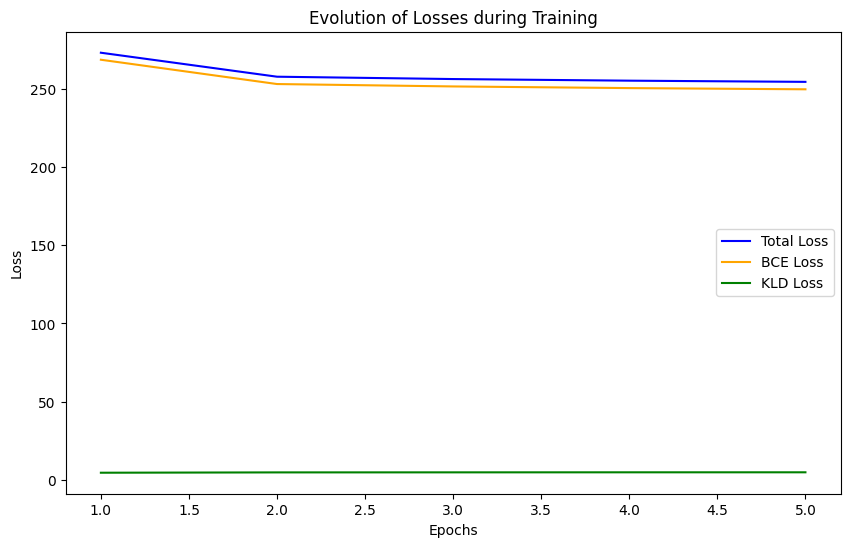

In [16]:
import matplotlib.pyplot as plt

# Initialisation du modèle VAE
vae = ConvVAE(latent_dim=latent_dim, num_classes=nb_classes)
vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Listes pour stocker les pertes de chaque époque
total_losses = []
bce_losses = []
kld_losses = []

# Entraînement du modèle
for epoch in range(1, epochs + 1):
    vae.train()
    running_loss = 0.0
    running_bce = 0.0
    running_kld = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=nb_classes).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data, labels)
        loss, bce, kld = loss_function_sep(recon_batch, data, mu, logvar, beta)
        loss.backward()
        optimizer.step()

        # Mise à jour des pertes
        running_loss += loss.item()
        running_bce += bce.item()
        running_kld += kld.item()
    
    # Calcul des pertes moyennes par époque
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_bce = running_bce / len(train_loader.dataset)
    epoch_kld = running_kld / len(train_loader.dataset)

    # Affichage de la perte par époque
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}, BCE: {epoch_bce:.4f}, KLD: {epoch_kld:.4f}')
    
    # Enregistrement des pertes
    total_losses.append(epoch_loss)
    bce_losses.append(epoch_bce)
    kld_losses.append(epoch_kld)

# Visualisation des courbes de perte
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), total_losses, label="Total Loss", color='blue')
plt.plot(range(1, epochs + 1), bce_losses, label="BCE Loss", color='orange')
plt.plot(range(1, epochs + 1), kld_losses, label="KLD Loss", color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution of Losses during Training')
plt.legend()
plt.show()


### Génération des images

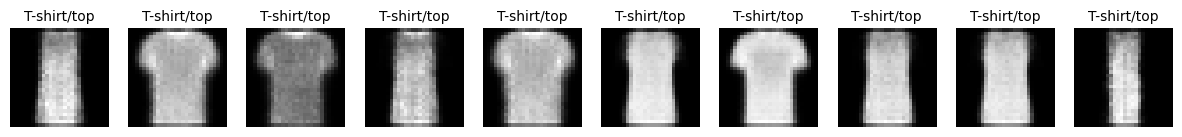

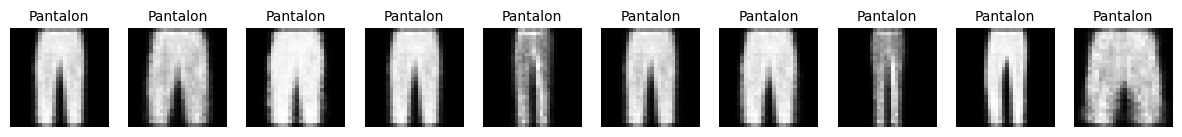

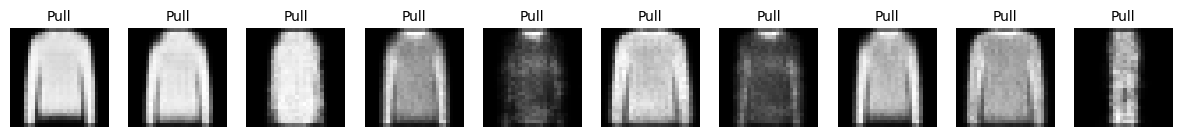

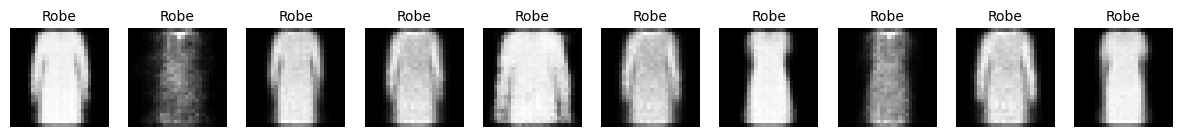

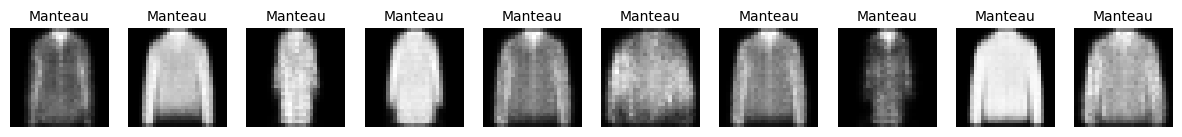

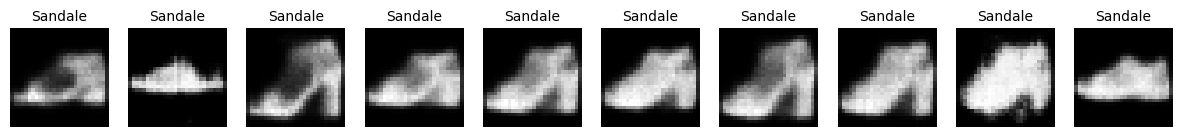

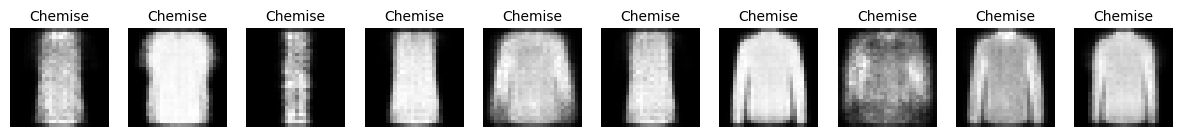

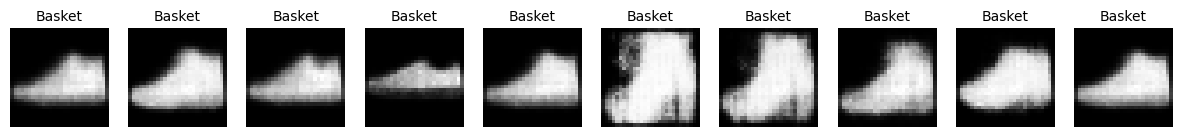

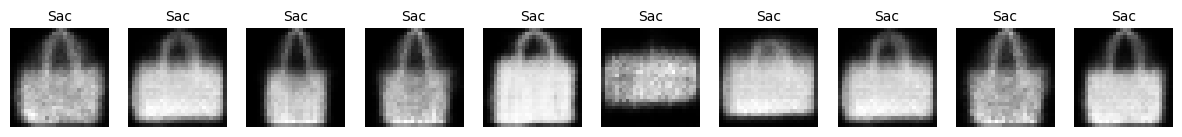

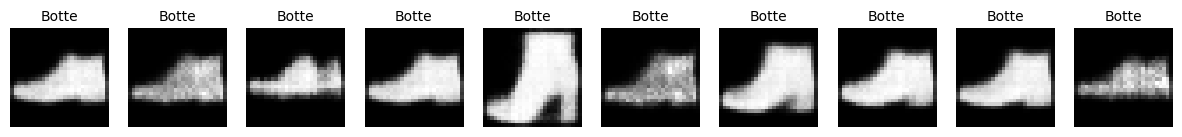

In [17]:
def generate_sample(num_samples=10, objet="robe"):
# digit est la valeur conditionelle c'est-à-dire la classe que l'on veut générer
    vae.eval()
    with torch.no_grad():

        # Échantillonage selon une loi normale
        z = torch.randn(num_samples, latent_dim).to(device)

        # On ajoute la condition ie la valeur que l'on veut générer
        condition = torch.zeros(num_samples,10, dtype=int).to(device)
        condition[:, objet] = 1 # indique que c'est la valeur digit que l'on cherche à générer

        # On génère l'image
        samples = vae.decode(z, condition)
        samples = samples.cpu().view(num_samples, 1, 28, 28)

        class_names = [
            "T-shirt/top", "Pantalon", "Pull", "Robe", "Manteau",
            "Sandale", "Chemise", "Basket", "Sac", "Botte"
        ]

        fig, ax = plt.subplots(1, num_samples, figsize=(15, 2))
        for i in range(num_samples):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
            ax[i].set_title(class_names[objet], fontsize=10)
        plt.show()


for classe in range(nb_classes):
    generate_sample(num_samples=10, objet=classe) # on génère 10 échantillons pour chaque classe

### Fonction de test

On cherche à évaluer les capacités de reconstruction du modèle sur des données non-vues (données test). S'il y a surapprentissage, on s'attend à ce que la fonction de perte calculée sur les données test soit plus élevée que la fonction de perte obtenue lors de l'apprentissage.

In [13]:
def evaluate_model(test_loader):
    vae.eval()  # Passage en mode évaluation
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(test_loader):
            data = data.to(device)
            labels = F.one_hot(labels, num_classes=nb_classes).to(device)
            recon_batch, mu, logvar = vae(data, labels)
            loss = loss_function(recon_batch, data, mu, logvar, beta)  # Fonction de perte utilisée lors de l'entraînement
            test_loss += loss.item()

    average_test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {average_test_loss:.4f}')


In [18]:
evaluate_model(test_loader)

Test Loss: 257.1277


La fonction de perte a une valeur proche de la dernière valeur obtenue lors de l'apprentissage. Il ne semble donc pas y avoir de surapprentissage.

### Visualisation de l'espace latent

On cherche à visualiser l'espace latent en utilisant différentes valeur du paramètre beta (qui contrôle pour rappel l'équilibre entre reconstruction et régularisation).


Training VAE with KL Weight = 0.5
Epoch 1: Average Loss: 279.3807, BCE: 276.1960, KLD: 6.3693
Epoch 2: Average Loss: 255.1713, BCE: 252.2073, KLD: 5.9281
Epoch 3: Average Loss: 253.3066, BCE: 250.3476, KLD: 5.9180
Epoch 4: Average Loss: 252.4844, BCE: 249.5143, KLD: 5.9402
Epoch 5: Average Loss: 251.9086, BCE: 248.9445, KLD: 5.9281


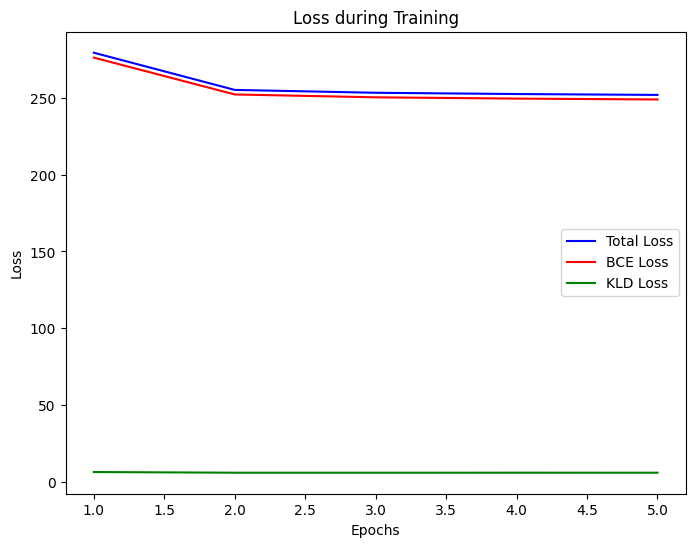

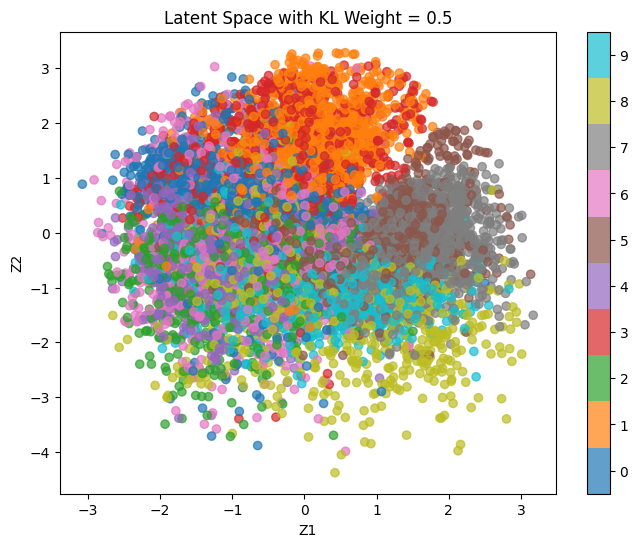


Training VAE with KL Weight = 1
Epoch 1: Average Loss: 273.5202, BCE: 268.5073, KLD: 5.0128
Epoch 2: Average Loss: 257.6526, BCE: 252.6092, KLD: 5.0435
Epoch 3: Average Loss: 256.1046, BCE: 251.0816, KLD: 5.0230
Epoch 4: Average Loss: 255.2827, BCE: 250.2768, KLD: 5.0060
Epoch 5: Average Loss: 254.3775, BCE: 249.3940, KLD: 4.9834


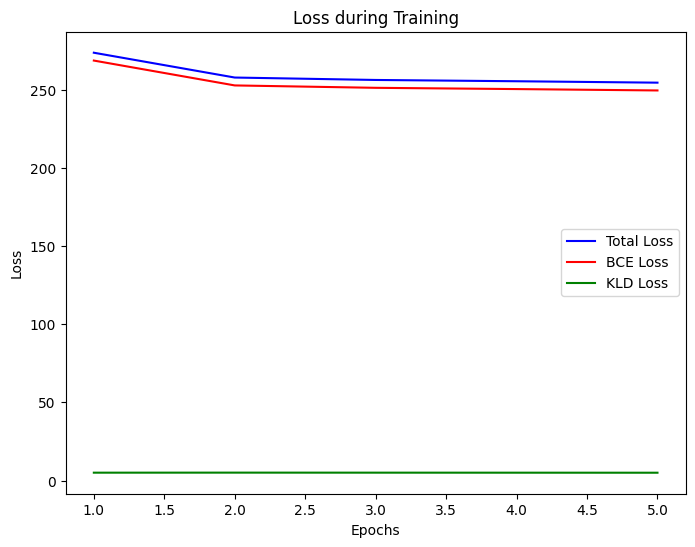

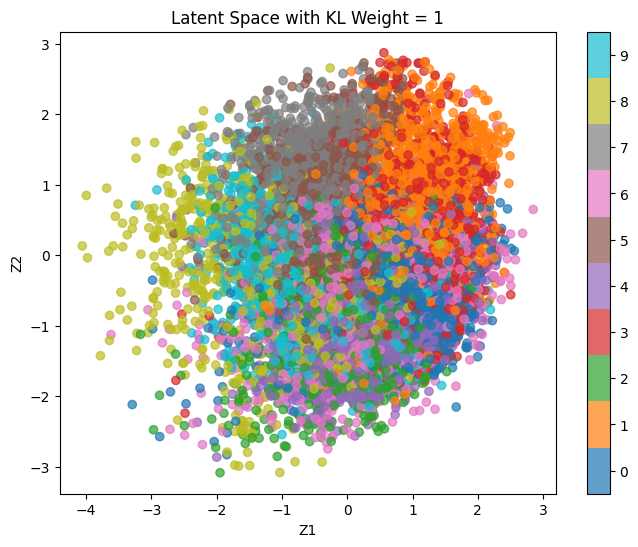


Training VAE with KL Weight = 10
Epoch 1: Average Loss: 294.9818, BCE: 278.8112, KLD: 1.6171
Epoch 2: Average Loss: 283.1651, BCE: 266.1688, KLD: 1.6996
Epoch 3: Average Loss: 281.4589, BCE: 264.2246, KLD: 1.7234
Epoch 4: Average Loss: 280.3004, BCE: 262.9554, KLD: 1.7345
Epoch 5: Average Loss: 279.6165, BCE: 262.2303, KLD: 1.7386


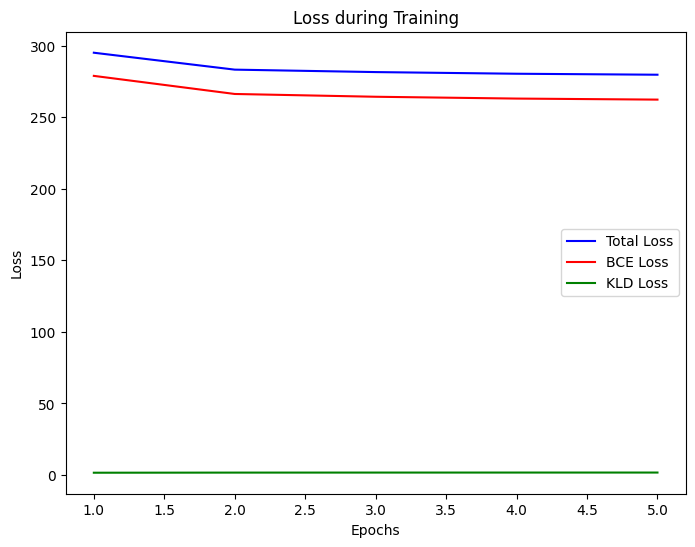

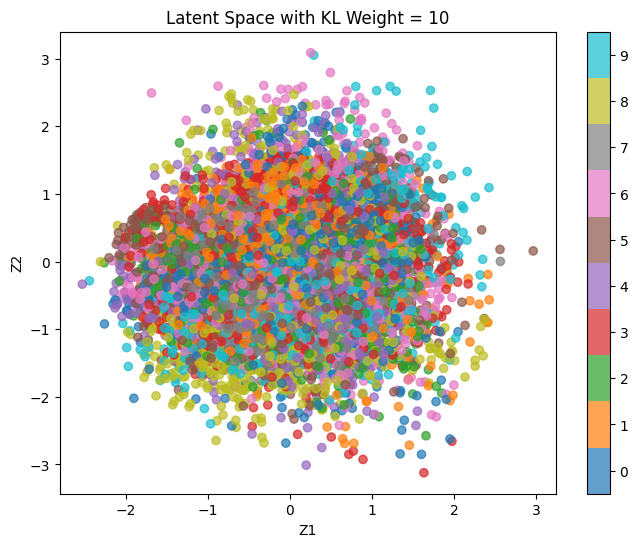


Training VAE with KL Weight = 100
Epoch 1: Average Loss: 320.2542, BCE: 318.4201, KLD: 0.0183
Epoch 2: Average Loss: 308.1961, BCE: 308.0429, KLD: 0.0015
Epoch 3: Average Loss: 307.8169, BCE: 307.6890, KLD: 0.0013
Epoch 4: Average Loss: 307.7479, BCE: 307.6324, KLD: 0.0012
Epoch 5: Average Loss: 307.6732, BCE: 307.5835, KLD: 0.0009


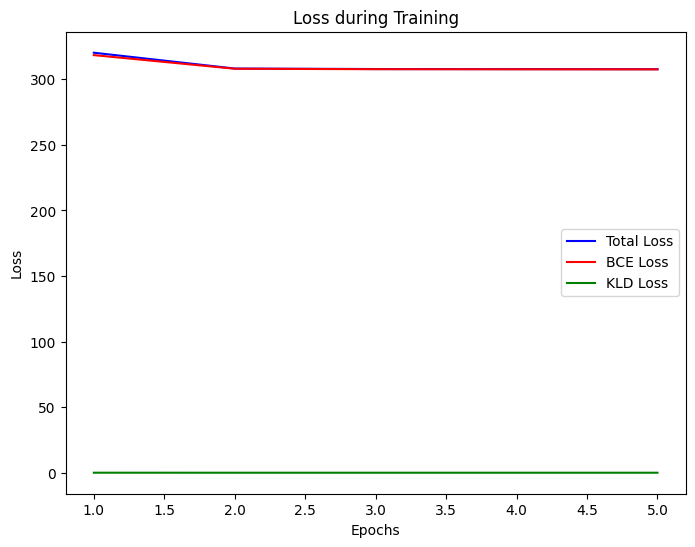

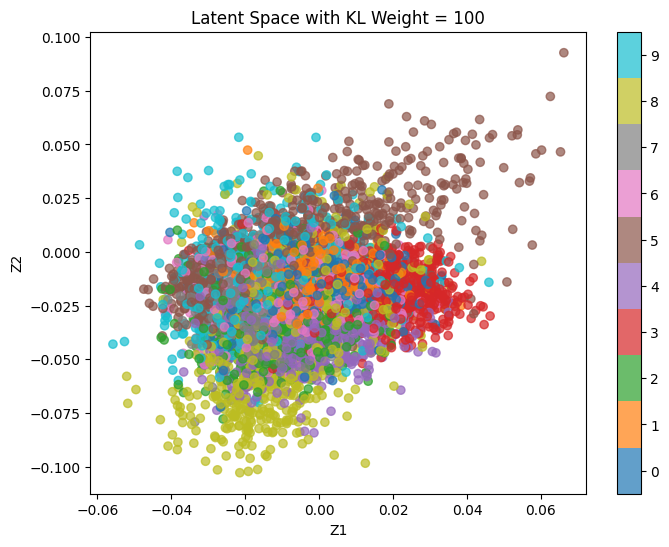

In [15]:
def train_and_plot(kl_weight):
    model = ConvVAE(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    bce_losses = []
    kld_losses = []
    
    model.train()
    
    for epoch in range(epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = F.one_hot(labels, num_classes=nb_classes).to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar = model(data, labels)
            loss, bce, kld = loss_function_sep(x_recon, data, mu, logvar, kl_weight)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
        
        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)
        
        # Stockage des valeurs pour la visualisation après l'entraînement
        train_losses.append(average_loss)
        bce_losses.append(average_bce)
        kld_losses.append(average_kld)
        
        print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')
    
    # Visualisation de la perte
    plot_loss(train_losses, bce_losses, kld_losses)
    
    # Visualisation de l'espace latent
    plot_latent_space(model, kl_weight)


def plot_loss(train_losses, bce_losses, kld_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Total Loss', color='blue')
    plt.plot(range(1, len(bce_losses) + 1), bce_losses, label='BCE Loss', color='red')
    plt.plot(range(1, len(kld_losses) + 1), kld_losses, label='KLD Loss', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss during Training')
    plt.legend()
    plt.show()

def plot_latent_space(model, kl_weight):
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=nb_classes).to(device)

        mu, logvar = model.encode(data, labels)
        z = mu  # Pour la visualisation on utilise la moyenne
        z = z.cpu().numpy()
        labels = labels.cpu().numpy()

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(z[:, 0], z[:, 1], c=np.argmax(labels, axis=1), cmap='tab10', alpha=0.7)  # On utilise np.argmax pour obtenir les classes
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with KL Weight = {kl_weight}')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()


# Visualisation de l'espace latent en fonction de la valeur de la divergence
for kl_weight in kl_weights:
    print(f'\nTraining VAE with KL Weight = {kl_weight}')
    train_and_plot(kl_weight)


Plus la valeur de la divergence augmente, plus on accentue la régularisation, c'est-à-dire que le modèle cherche davantage à ce que z1 et z2 s'approche d'une loi gaussienne. Cela se fait donc potentiellement au détriment de la reconstruction. <br>
De fait, sur les figures ci-dessus, on constate que, quelle que soit la valeur de beta utilisée, il y a enchevêtrement des classes. Mais les classes se distinguent d'autant moins les unes des autres que la valeur de beta est élevée. Or, dans notre cas, puisque l'on veut ensuite générer des images, il serait préférable d'avoir un espace latent dans lequel les classes sont bien distinctes les unes des autres. Il vaudrait donc mieux travailler avec des valeurs de beta qui ne soient pas trop élevées.

En outre, on remarque que plus beta augmente, plus la valeur du terme de divergence (KLD) diminue et que les valeurs de la binary cross-entropy (BCE) et de la fonction de perte en général augmentent très largement (on passe d'une loss de 251 pour beta valant 0.5 à une loss de 307 pour beta valant 100). <br>
Ainsi, il semble plus interessant d'avoir une KLD plus élevée pour contraindre la distribution latente de $q(z|x,c)$ à se rapprocher de celle de $p(z|c)$ tout en réduisant au maximum les valeurs de la BCE et de la fonction de perte (signes d'une meilleure reconstruction)

## Optimisation des paramètres et nouvelle génération d'images

L'objectif de cette section est de tester différentes combinaisons d'hyperparamètres afin de déterminer celle qui est la plus optimale. Pour cela, pour chaque combinaison on calcule la valeur de la fonction de perte obtenue à la fin de l'apprentissage. On regarde alors quelle combinaison nous permet d'avoir une valeur minimale. Nos images seront ensuite générées avec cette combinaison d'hyperparamètres.

Afin de limiter les temps de calcul, 3 valeurs ont été testées pour chaque hyperparamètre que l'on a voulu optimiser.

### Recherche des paramètres optimaux

In [ ]:
# Liste des hyperparamètres
batch_size_list = [32, 64, 128]
epochs_list = [5, 10, 50]
latent_dim_list = [2, 10, 64]
beta_list = [0.5, 1, 2] # faibles valeurs puisque la première partie a montré qu'elles semblaient plus pertinentes

def Optimisation(batch_size_list, epochs_list, latent_dim_list, beta_list) :
    combinations = list(itertools.product(batch_size_list, epochs_list, latent_dim_list, beta_list))
    loss_list = []
    param_list = []

    for batch_size_opt, epochs_opt, latent_dim_opt, beta_opt in  combinations:
        train_loader_opt = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_opt, shuffle=True)
        test_loader_opt = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size_opt, shuffle=False)

        # Initialisation du modèle de VAE model
        vae = ConvVAE(latent_dim=latent_dim_opt, num_classes=nb_classes)
        vae.to(device)
        optimizer = optim.Adam(vae.parameters(), lr=learning_rate) 
        # On choisit l'optimizer Adam, couramment utilisé dans l'industrie pour ses performances

        # On entraîne le modèle sur chaque epoch
        for epoch in range(1, epochs_opt + 1):
            vae.train()
            running_loss = 0.0
            for batch_idx, (data, labels) in enumerate(train_loader_opt):
                data = data.to(device)
                labels = F.one_hot(labels, num_classes=nb_classes).to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar = vae(data, labels)
                loss = loss_function(recon_batch, data, mu, logvar, beta_opt)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            
            epoch_loss = running_loss / len(train_loader_opt.dataset)
        loss_list.append(epoch_loss)
        param_list.append([batch_size_opt, epochs_opt, latent_dim_opt, beta_opt])

    print(f"Valeur minimale de la fonction de perte : {min(loss_list)}, pour les paramètres suivants :")
    print(f"batch_size_opt : {param_list[loss_list.index(min(loss_list))][0]}")
    print(f"epochs_opt : {param_list[loss_list.index(min(loss_list))][1]}")
    print(f"latent_dim_opt : {param_list[loss_list.index(min(loss_list))][2]}")
    print(f"beta_opt : {param_list[loss_list.index(min(loss_list))][3]}")


In [24]:
Optimisation(batch_size_list, epochs_list, latent_dim_list, beta_list)

Valeur minimale de la fonction de perte : 224.15730145670574, pour les paramètres suivants :
batch_size_opt : 64
epochs_opt : 50
latent_dim_opt : 64
beta_opt : 0.5


### Influence des différents paramètres

On va ensuite chercher à voir l'influence de chaque paramètre sur les valeurs de la fonction de perte. Cette fois-ci, pour chaque graphe obtenu, 3 des 4 paramètres sont fixés tandis que le troisème varie.

In [6]:
# Liste des hyperparamètres
batch_size_list = [32, 64, 128]
epochs_list = [5, 10, 50]
latent_dim_list = [2, 10, 64]
beta_list = [0.5, 1, 2]

def apprentissage(batch_size_opt, epochs_opt, latent_dim_opt, beta_opt):
    loss_list = []
    param_list = []

    train_loader_opt = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_opt, shuffle=True)

    # Initialisation du modèle de VAE model
    vae = ConvVAE(latent_dim=latent_dim_opt, num_classes=nb_classes)
    vae.to(device)
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate) 
    # On choisit l'optimizer Adam, couramment utilisé dans l'industrie pour ses performances

    # On entraîne le modèle sur chaque epoch
    for epoch in range(1, epochs_opt + 1):
        vae.train()
        running_loss = 0.0
        for batch_idx, (data, labels) in enumerate(train_loader_opt):
            data = data.to(device)
            labels = F.one_hot(labels, num_classes=nb_classes).to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data, labels)
            loss = loss_function(recon_batch, data, mu, logvar, beta_opt)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader_opt.dataset)
    loss_list.append(epoch_loss)
    param_list.append([batch_size_opt, epochs_opt, latent_dim_opt, beta_opt])
    return(loss_list, param_list)




def Optimisation_graphe(batch_size_list, epochs_list, latent_dim_list, beta_list) :
    xb = []
    lossb = []
    xe = []
    losse = []
    xl = []
    lossl = []
    xbe = []
    lossbe = []
    
    for batch_opt in batch_size_list :
        torch.cuda.empty_cache()
        loss_batch, param_batch = apprentissage(batch_opt, epochs, latent_dim, beta)
        xb.append(batch_opt)
        lossb.append(loss_batch)

    plt.plot(xb, lossb, label='Fonction de perte pour des batchs différents')
    plt.xlabel('Batch')
    plt.ylabel('Fonction de perte')
    plt.legend()
    plt.show()

    for epochs_opt in epochs_list :
        torch.cuda.empty_cache()
        loss_epoch, param_epoch = apprentissage(batch_size, epochs_opt, latent_dim, beta)
        xe.append(epochs_opt)
        losse.append(loss_epoch)

    plt.plot(xe, losse, label='Fonction de perte pour des epochs différents')
    plt.xlabel('Epochs')
    plt.ylabel('Fonction de perte')
    plt.legend()
    plt.show()

    for latent_dim_opt in latent_dim_list :
        torch.cuda.empty_cache()
        loss_latent, param_latent = apprentissage(batch_size, epochs, latent_dim_opt, beta)
        xl.append(latent_dim_opt)
        lossl.append(loss_latent)

    plt.plot(xl, lossl, label='Fonction de perte pour des espaces latents différents')
    plt.xlabel('Espaces Latents')
    plt.ylabel('Fonction de perte')
    plt.legend()
    plt.show()

    for beta_opt in beta_list :
        torch.cuda.empty_cache()
        loss_beta, param_beta = apprentissage(batch_size, epochs, latent_dim, beta_opt)
        xbe.append(beta_opt)
        lossbe.append(loss_beta)

    plt.plot(xbe, lossbe, label='Fonction de perte pour des beta différents')
    plt.xlabel('Beta')
    plt.ylabel('Fonction de perte')
    plt.legend()
    plt.show()
    

On fixe initialement nos paramètres en utilisant les valeurs optimales calculées précédemment et à chaque fois on ne fait varier qu'un seul des quatre paramètres.

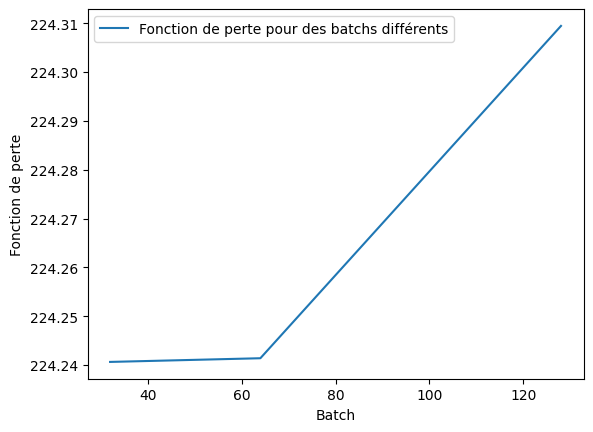

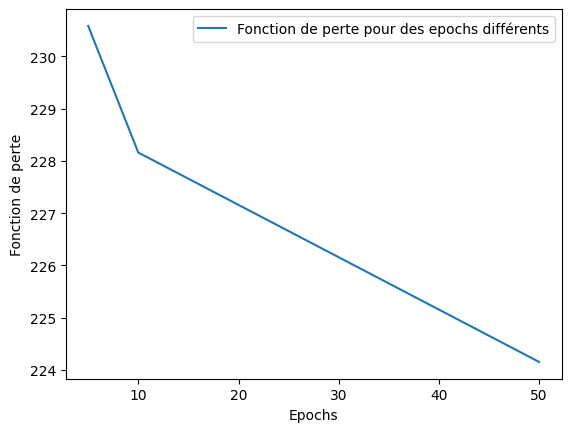

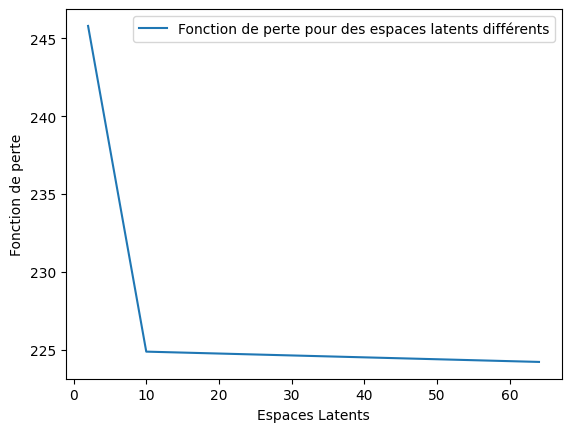

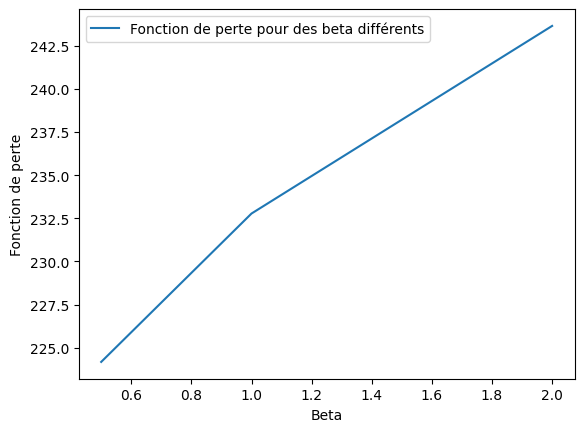

In [7]:
# Liste des hyperparamètres optimaux
batch_size = 64
epochs = 50
latent_dim = 64
beta = 0.5

Optimisation_graphe(batch_size_list, epochs_list, latent_dim_list, beta_list)

Les résultats obtenus permettent de conclure de la manière suivante :

- La taille du batch semble avoir peut d'influence sur les valeurs de la fonction perte.
- En revanche, les trois autres paramètres influencent fortement les valeurs de la fonction de perte :
   - Plus le nombre d'epochs est grand, plus la fonction de perte est faible. Cela semble logique car le modèle utilise davantage l'ensemble de données pour l'apprentissage.
  - De même, plus la taille de l'espace latent est grande, plus la fonction de perte est faible. En fait, plus la taille de l'espace latent est grande, plus le modèle capture davantage de nuances et de détails dans les données.
  - Enfin, plus beta est faible, plus la fonction de perte est faible. Là encore cela semble logique puisqu'en utilisant un beta plus faible, on donne davantage de poids à la reconstruction.
 
Ainsi, en augmentant le nombre d'epochs et la taille de l'espace latent, et en diminuant beta, on améliore les valeurs de la fonction de perte mais on augmente le risque de surapprentissage. Cependant, faire ce choix nous permet de générer des images proches de ce qui est attendu pour chaque classe de vêtements (plus qu'avec d'autres choix de paramètres) et justifie que l'on ait décidé de travailler avec ces paramètres optimaux (on favorise une meilleure reconstruction pour générer des images de meilleure qualité).

### Nouvelle génération d'images avec les paramètres optimisés

Epoch 1, Training loss: 259.5790, BCE: 246.1724, KLD: 26.8133
Epoch 2, Training loss: 237.4797, BCE: 225.0432, KLD: 24.8730
Epoch 3, Training loss: 234.0237, BCE: 221.6768, KLD: 24.6939
Epoch 4, Training loss: 232.2880, BCE: 220.0268, KLD: 24.5225
Epoch 5, Training loss: 231.1213, BCE: 218.9431, KLD: 24.3565
Epoch 6, Training loss: 230.3714, BCE: 218.2707, KLD: 24.2014
Epoch 7, Training loss: 229.6729, BCE: 217.6504, KLD: 24.0451
Epoch 8, Training loss: 229.1310, BCE: 217.1826, KLD: 23.8968
Epoch 9, Training loss: 228.7020, BCE: 216.8188, KLD: 23.7664
Epoch 10, Training loss: 228.3405, BCE: 216.4941, KLD: 23.6928
Epoch 11, Training loss: 228.0565, BCE: 216.2643, KLD: 23.5845
Epoch 12, Training loss: 227.7569, BCE: 216.0008, KLD: 23.5121
Epoch 13, Training loss: 227.5317, BCE: 215.8174, KLD: 23.4286
Epoch 14, Training loss: 227.2811, BCE: 215.5958, KLD: 23.3706
Epoch 15, Training loss: 227.0211, BCE: 215.3773, KLD: 23.2876
Epoch 16, Training loss: 226.9189, BCE: 215.2949, KLD: 23.2480
E

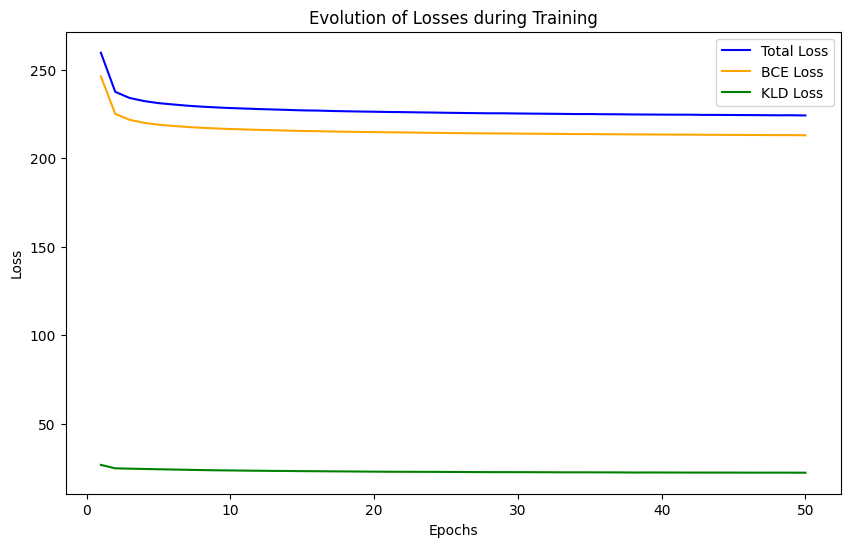

In [19]:
batch_size = 64
epochs = 50
latent_dim = 64
beta = 0.5

# Initialisation du modèle VAE avec les paramètres optimaux
vae = ConvVAE(latent_dim=latent_dim, num_classes=nb_classes)
vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Listes pour stocker les pertes de chaque époque
total_losses = []
bce_losses = []
kld_losses = []

# Entraînement du modèle avec les paramètres optimaux
for epoch in range(1, epochs + 1):
    vae.train()
    running_loss = 0.0
    running_bce = 0.0
    running_kld = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=nb_classes).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data, labels)
        loss, bce, kld = loss_function_sep(recon_batch, data, mu, logvar, beta)
        loss.backward()
        optimizer.step()

        # Mise à jour des pertes
        running_loss += loss.item()
        running_bce += bce.item()
        running_kld += kld.item()
    
    # Calcul des pertes moyennes par époque
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_bce = running_bce / len(train_loader.dataset)
    epoch_kld = running_kld / len(train_loader.dataset)

    # Affichage de la perte par époque
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}, BCE: {epoch_bce:.4f}, KLD: {epoch_kld:.4f}')
    
    # Enregistrement des pertes
    total_losses.append(epoch_loss)
    bce_losses.append(epoch_bce)
    kld_losses.append(epoch_kld)

# Visualisation des courbes de perte
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), total_losses, label="Total Loss", color='blue')
plt.plot(range(1, epochs + 1), bce_losses, label="BCE Loss", color='orange')
plt.plot(range(1, epochs + 1), kld_losses, label="KLD Loss", color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution of Losses during Training')
plt.legend()
plt.show()

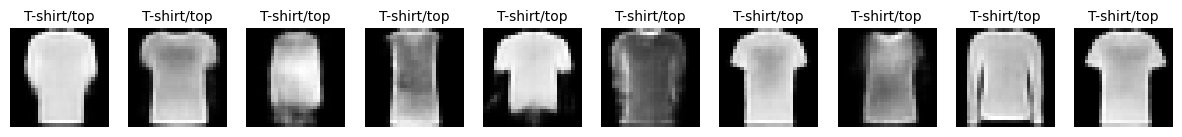

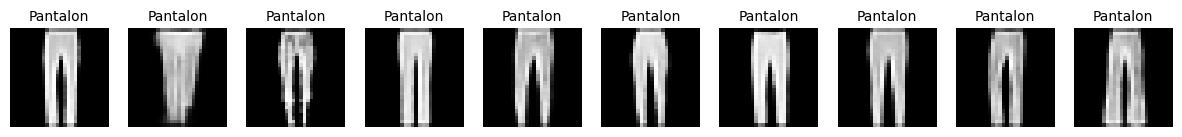

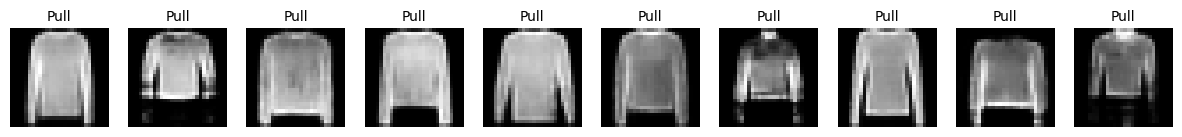

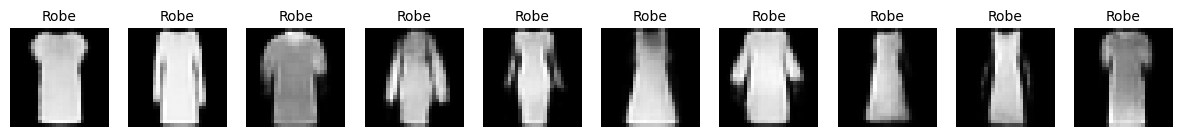

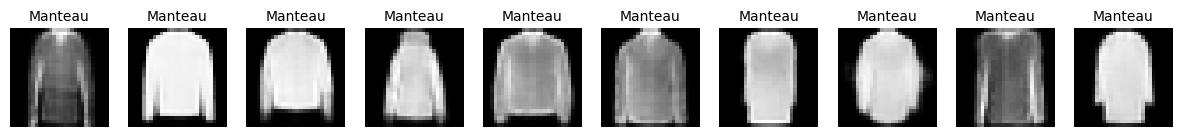

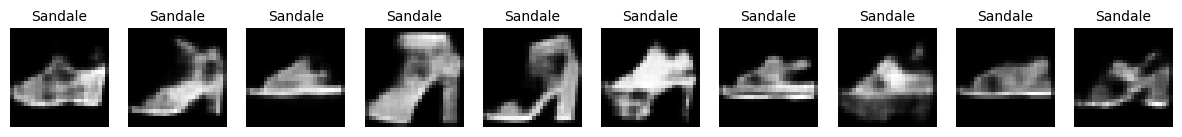

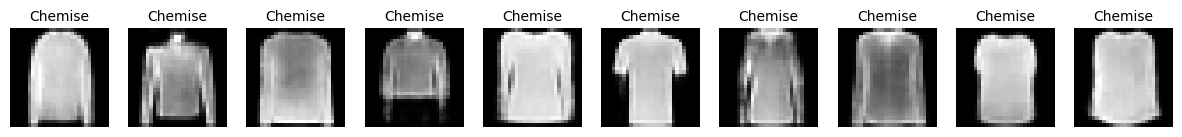

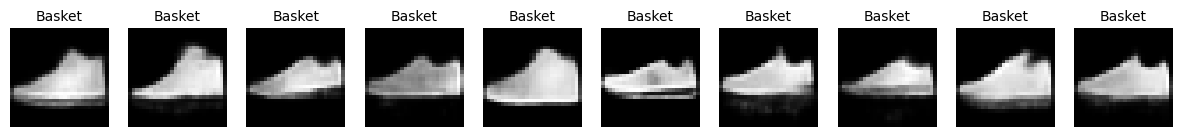

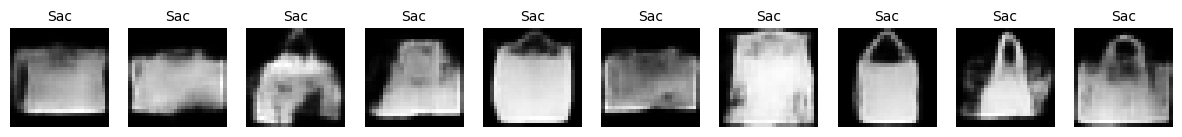

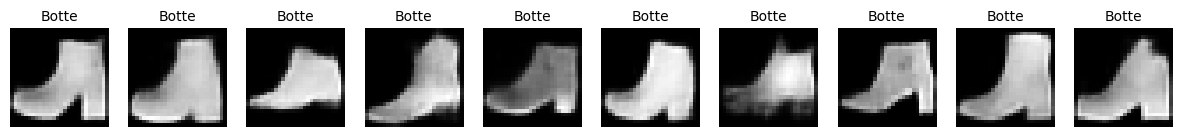

In [21]:
for classe in range(nb_classes):
    generate_sample(num_samples=10, objet=classe) # on génère 10 échantillons pour chaque classe

### Capacité de généralisation

In [ ]:
evaluate_model(test_loader) # on calcule la perte sur l'echantillon test

Test Loss: 226.6845


Là encore la valeur de perte du test est proche de celle de la dernière itération de l'apprentissage montrant les capacités de généralisation du modèle. Le choix des paramètres optimaux n'a donc pas entraîné de surapprentissage au final.

### Visualisation de l'espace latent

La visualisation de l'espace latent est ici moins aisée qu'avec le modèle "naïf utilisé" au départ puisque la dimension de l'espace latent n'est plus de 2 mais de 64. 

Malgré tout, certaines méthodes ont été envisagées pour tenter de visualiser l'espace latent sur un espace 2D : ACP ou t-SNE qui permettent une réduction de dimension. Mais la projection des données sur 2 axes n'a pas été considérée comme satisfaisante, ni dans un cas, ni dans l'autre.